In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Load Data

In [3]:
FPTdf = pd.read_csv("FPT.csv", parse_dates=['Date/Time'], index_col=1)
FPTdf = FPTdf.drop(columns=["Open Interest"])
FPTdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97406 entries, 2018-12-25 09:15:00 to 2020-12-22 14:46:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  97406 non-null  object 
 1   Open    97406 non-null  float64
 2   High    97406 non-null  float64
 3   Low     97406 non-null  float64
 4   Close   97406 non-null  float64
 5   Volume  97406 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 5.2+ MB


## Plotting Outliers

In [6]:
FPTdf['Year'] = FPTdf.index.year
FPTdf.head(9)

,Ticker,Open,High,Low,Close,Volume,Year
Date/Time,,,,,,,
2018-12-25 09:15:00,FPT,30.89,30.89,30.89,30.89,35410,2018
2018-12-25 09:16:00,FPT,30.81,30.81,30.81,30.81,190,2018
2018-12-25 09:17:00,FPT,30.74,30.81,30.74,30.74,1120,2018
2018-12-25 09:18:00,FPT,30.74,30.74,30.74,30.74,2120,2018
2018-12-25 09:19:00,FPT,30.74,30.74,30.74,30.74,22500,2018
2018-12-25 09:20:00,FPT,30.74,30.74,30.70,30.74,7140,2018
2018-12-25 09:21:00,FPT,30.66,30.74,30.59,30.66,16480,2018
2018-12-26 09:15:00,FPT,31.04,31.11,31.04,31.11,2650,2018
2018-12-26 09:16:00,FPT,31.19,31.19,31.19,31.19,500,2018


<Axes: xlabel='Year', ylabel='Open'>

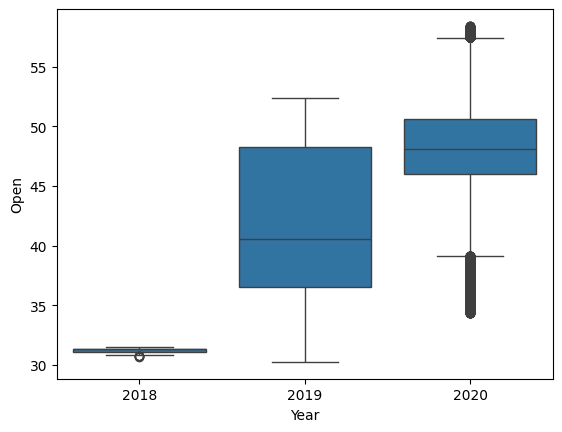

In [7]:
sns.boxplot(data=FPTdf, x="Year", y="Open")

# Training Data Without Extracting Outliers

## Preparing Data

In [23]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(FPTdf['Close'].values.reshape(-1, 1))
prediction_days = 60

x_train = []
y_train = []


for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x - prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])
  
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Build and Train model

In [25]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error")
history = model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
3043/3043 [==============================] - 160s 51ms/step - loss: 0.0018
Epoch 2/25
3043/3043 [==============================] - 168s 55ms/step - loss: 5.2273e-04
Epoch 3/25
3043/3043 [==============================] - 180s 59ms/step - loss: 4.3031e-04
Epoch 4/25
3043/3043 [==============================] - 165s 54ms/step - loss: 4.0405e-04
Epoch 5/25
3043/3043 [==============================] - 158s 52ms/step - loss: 3.9420e-04
Epoch 6/25
3043/3043 [==============================] - 157s 51ms/step - loss: 3.8419e-04
Epoch 7/25
3043/3043 [==============================] - 156s 51ms/step - loss: 3.7466e-04
Epoch 8/25
3043/3043 [==============================] - 157s 52ms/step - loss: 3.7570e-04
Epoch 9/25
3043/3043 [==============================] - 151s 50ms/step - loss: 3.6436e-04
Epoch 10/25
3043/3043 [==============================] - 150s 49ms/step - loss: 3.6897e-04
Epoch 11/25
3043/3043 [==============================] - 147s 48ms/step - loss: 3.6077e-04
Epoch 12/25


## Testing the Accuracy

In [28]:
test_start = dt.datetime(2021, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download("FPT", test_start, test_end)
actual_prices = test_data["Close"].values
total_dataset = pd.concat((FPTdf["Close"], test_data["Close"]), axis=0)

d:\DELL\Desktop\COS30018\COS30018\ProjectAssessment\TaskB1\myenv\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [32]:
prediction_days = 60
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [31]:
print(model_inputs)

[[5.76000000e+01]
 [5.75000000e+01]
 [5.75000000e+01]
 [5.75000000e+01]
 [5.76000000e+01]
 [5.76000000e+01]
 [5.75000000e+01]
 [5.76000000e+01]
 [5.76000000e+01]
 [5.75000000e+01]
 [5.75000000e+01]
 [5.76000000e+01]
 [5.75000000e+01]
 [5.76000000e+01]
 [5.76000000e+01]
 [5.76000000e+01]
 [5.75000000e+01]
 [5.76000000e+01]
 [5.76000000e+01]
 [5.77000000e+01]
 [5.77000000e+01]
 [5.77000000e+01]
 [5.77000000e+01]
 [5.78000000e+01]
 [5.79000000e+01]
 [5.79000000e+01]
 [5.79000000e+01]
 [5.78000000e+01]
 [5.79000000e+01]
 [5.80000000e+01]
 [5.80000000e+01]
 [5.80000000e+01]
 [5.81000000e+01]
 [5.82000000e+01]
 [5.84000000e+01]
 [5.84000000e+01]
 [5.83000000e+01]
 [5.84000000e+01]
 [5.84000000e+01]
 [5.83000000e+01]
 [5.82000000e+01]
 [5.83000000e+01]
 [5.82000000e+01]
 [5.81000000e+01]
 [5.82000000e+01]
 [5.82000000e+01]
 [5.81000000e+01]
 [5.81000000e+01]
 [5.81000000e+01]
 [5.81000000e+01]
 [5.81000000e+01]
 [5.81000000e+01]
 [5.81000000e+01]
 [5.81000000e+01]
 [5.82000000e+01]
 [5.820000